In [10]:
!pip uninstall -y qiskit qiskit-aer qiskit-ibm-provider qiskit_ibm_runtime qiskit-ibm-runtime aer
!pip install -U qiskit qiskit-aer qiskit-ibm-runtime --quiet
!pip install pylatexenc


Found existing installation: qiskit 2.2.3
Uninstalling qiskit-2.2.3:
  Successfully uninstalled qiskit-2.2.3
Found existing installation: qiskit-aer 0.17.2
Uninstalling qiskit-aer-0.17.2:
  Successfully uninstalled qiskit-aer-0.17.2
Found existing installation: qiskit-ibm-runtime 0.43.1
Uninstalling qiskit-ibm-runtime-0.43.1:
  Successfully uninstalled qiskit-ibm-runtime-0.43.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=e969f9828ece8fb3c5da4faa4c1846c5652317ecb1a9c9a26047d1763e935160
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


✅ Grover circuit built successfully!

⚠️ Could not draw circuit graphically. Showing text view instead:
      ┌───┐┌──────────────┐┌───────────┐┌──────────────┐┌───────────┐┌─┐      
q4_0: ┤ H ├┤0             ├┤0          ├┤0             ├┤0          ├┤M├──────
      ├───┤│              ││           ││              ││           │└╥┘┌─┐   
q4_1: ┤ H ├┤1 Oracle(011) ├┤1 Diffuser ├┤1 Oracle(011) ├┤1 Diffuser ├─╫─┤M├───
      ├───┤│              ││           ││              ││           │ ║ └╥┘┌─┐
q4_2: ┤ H ├┤2             ├┤2          ├┤2             ├┤2          ├─╫──╫─┤M├
      └───┘└──────────────┘└───────────┘└──────────────┘└───────────┘ ║  ║ └╥┘
c4: 3/════════════════════════════════════════════════════════════════╩══╩══╩═
                                                                      0  1  2 

📊 Ideal simulator results: {'100': 9, '001': 17, '000': 20, '010': 14, '101': 17, '110': 16, '111': 21, '011': 1934}

🧩 Creating synthetic depolarizing noise model...

⚡ Noisy simulato

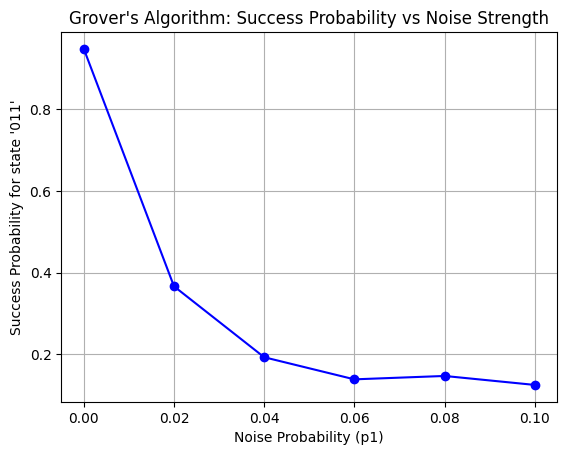


🔍 Running optimal iteration count experiment...


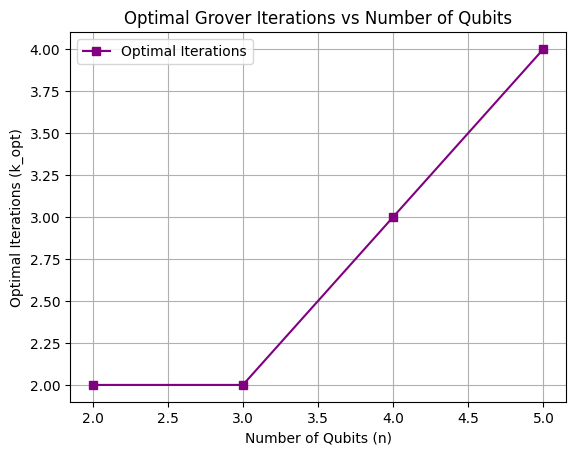

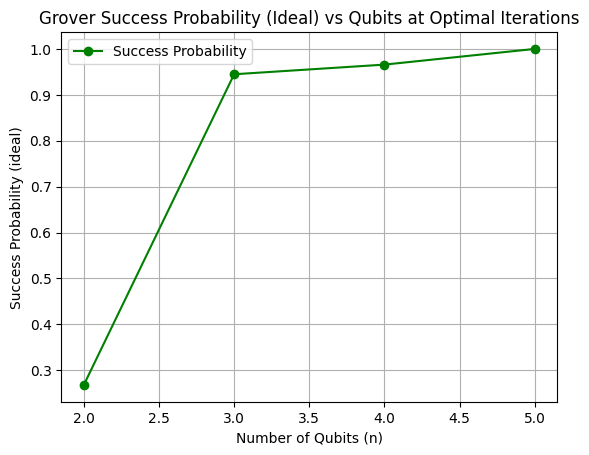

In [14]:
# =========================================================
# ✅ INSTALL REQUIRED LIBRARIES
# =========================================================
!pip install -q qiskit qiskit-aer pylatexenc matplotlib numpy

# =========================================================
# ✅ IMPORTS
# =========================================================
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator, noise
import matplotlib.pyplot as plt
import numpy as np
from math import pi, sqrt

# =========================================================
# ⚙️ HELPER FUNCTIONS
# =========================================================

def make_oracle(n_qubits, marked_state: str):
    """Create an oracle that flips the phase of the marked_state."""
    qc = QuantumCircuit(n_qubits, name=f"Oracle({marked_state})")
    for i, bit in enumerate(reversed(marked_state)):
        if bit == '0':
            qc.x(i)
    if n_qubits == 1:
        qc.z(0)
    else:
        target = n_qubits - 1
        qc.h(target)
        qc.mcx(list(range(target)), target)
        qc.h(target)
    for i, bit in enumerate(reversed(marked_state)):
        if bit == '0':
            qc.x(i)
    return qc.to_gate()

def diffuser(n_qubits):
    """Grover diffuser (inversion about the mean)."""
    qc = QuantumCircuit(n_qubits, name="Diffuser")
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    if n_qubits == 1:
        qc.z(0)
    else:
        target = n_qubits - 1
        qc.h(target)
        qc.mcx(list(range(target)), target)
        qc.h(target)
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    return qc.to_gate()

def build_grover_circuit(n_qubits, marked_state, iterations=1):
    """Build Grover search circuit for a marked state."""
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    qc = QuantumCircuit(qr, cr)
    qc.h(qr)
    oracle = make_oracle(n_qubits, marked_state)
    diff = diffuser(n_qubits)
    for _ in range(iterations):
        qc.append(oracle, qr)
        qc.append(diff, qr)
    qc.measure(qr, cr)
    return qc

def run_simulation(qc, simulator, shots=2048):
    """Run circuit on the given simulator."""
    tqc = transpile(qc, simulator)
    result = simulator.run(tqc, shots=shots).result()
    return result.get_counts()

# =========================================================
# 🧠 USER PARAMETERS
# =========================================================
n_qubits = 3
marked_state = '011'   # Try '001', '010', '111', etc.
iterations = 2
shots = 2048

# =========================================================
# 1️⃣ Build and visualize the circuit
# =========================================================
if len(marked_state) != n_qubits:
    raise ValueError("marked_state length must equal n_qubits")

qc = build_grover_circuit(n_qubits, marked_state, iterations)
print("✅ Grover circuit built successfully!\n")

try:
    display(qc.draw('mpl'))
except Exception:
    print("⚠️ Could not draw circuit graphically. Showing text view instead:")
    print(qc.draw())

# =========================================================
# 2️⃣ Run ideal simulation (no noise)
# =========================================================
ideal_sim = AerSimulator()
ideal_counts = run_simulation(qc, ideal_sim, shots)
print("\n📊 Ideal simulator results:", ideal_counts)

# =========================================================
# 3️⃣ Build synthetic noise model
# =========================================================
print("\n🧩 Creating synthetic depolarizing noise model...")
noise_model = noise.NoiseModel()

# Depolarizing noise parameters
p1 = 0.01  # single-qubit gate error probability
p2 = 0.02  # two-qubit gate error probability
dep1 = noise.depolarizing_error(p1, 1)
dep2 = noise.depolarizing_error(p2, 2)
noise_model.add_all_qubit_quantum_error(dep1, ['x', 'h', 'z', 'u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(dep2, ['cx'])

noisy_sim = AerSimulator(noise_model=noise_model)

# =========================================================
# 4️⃣ Run noisy simulation
# =========================================================
noisy_counts = run_simulation(qc, noisy_sim, shots)
print("\n⚡ Noisy simulator results:", noisy_counts)

# =========================================================
# 5️⃣ Compare Ideal vs Noisy Histograms
# =========================================================
plot_histogram([ideal_counts, noisy_counts],
               legend=['Ideal', 'Noisy'],
               title=f"Grover Search (n={n_qubits}, marked='{marked_state}', iterations={iterations})")
plt.show()

# =========================================================
# 6️⃣ Noise Strength vs Success Probability Experiment
# =========================================================
print("\n📈 Running noise vs success probability experiment...")
p_values = np.linspace(0, 0.1, 6)  # noise levels from 0 to 10%
success_probs = []

for p in p_values:
    noise_model = noise.NoiseModel()
    dep1 = noise.depolarizing_error(p, 1)
    dep2 = noise.depolarizing_error(p * 1.5, 2)
    noise_model.add_all_qubit_quantum_error(dep1, ['x', 'h', 'z', 'u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(dep2, ['cx'])

    noisy_sim = AerSimulator(noise_model=noise_model)
    counts = run_simulation(qc, noisy_sim, shots)
    prob = counts.get(marked_state, 0) / shots
    success_probs.append(prob)

# Plot
plt.plot(p_values, success_probs, marker='o', linestyle='-', color='b')
plt.title("Grover's Algorithm: Success Probability vs Noise Strength")
plt.xlabel("Noise Probability (p1)")
plt.ylabel(f"Success Probability for state '{marked_state}'")
plt.grid(True)
plt.show()

# =========================================================
# 7️⃣ Optimal Iteration Count vs Qubits
# =========================================================
print("\n🔍 Running optimal iteration count experiment...")
qubit_counts = [2, 3, 4, 5]
opt_iters = []
ideal_success = []

for n in qubit_counts:
    marked = '0' * (n - 1) + '1'  # mark last qubit as '1'
    N = 2 ** n
    k_opt = round((pi / 4) * sqrt(N))  # theoretical optimal iteration count
    opt_iters.append(k_opt)

    # Build circuit for this configuration
    qc_opt = build_grover_circuit(n, marked, iterations=k_opt)
    ideal_sim = AerSimulator()
    counts = run_simulation(qc_opt, ideal_sim, shots)
    success_prob = counts.get(marked, 0) / shots
    ideal_success.append(success_prob)

plt.plot(qubit_counts, opt_iters, marker='s', color='purple', label='Optimal Iterations')
plt.title("Optimal Grover Iterations vs Number of Qubits")
plt.xlabel("Number of Qubits (n)")
plt.ylabel("Optimal Iterations (k_opt)")
plt.grid(True)
plt.legend()
plt.show()

# Plot success probabilities for those optimal iterations
plt.plot(qubit_counts, ideal_success, marker='o', color='green', label='Success Probability')
plt.title("Grover Success Probability (Ideal) vs Qubits at Optimal Iterations")
plt.xlabel("Number of Qubits (n)")
plt.ylabel("Success Probability (ideal)")
plt.grid(True)
plt.legend()
plt.show()
